In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pingouin as pg
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

%matplotlib widget
sns.set_palette("pastel")
palette = sns.color_palette("pastel")

<h1 style="text-align:center">Dataset Loading</h1>

In [1]:
data = pd.read_excel("data/Telomere MDD.xlsx")

In [2]:
palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [9]:
from itertools import combinations

In [ ]:
pairs = list(combinations([0, 1, 2, 3, 5, 6, 9], r=2))

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.799e-01 U_stat=5.900e+01
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=9.000e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.203e-01 U_stat=9.400e+01
3 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:6.889e-01 U_stat=3.100e+01
5 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.200e+01
6 vs. 9: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=0.000e+00
0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.144e-02 U_stat=9.300e+01
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.403e-01 U_stat=5.300e+01
2 vs. 5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.365e-01 U_stat=7.700e+01
3 vs. 6: Mann-Whitney-Wilcoxon test two-sided, P_val:2.601e-01 U_stat=2.600e+01
5 vs. 9:

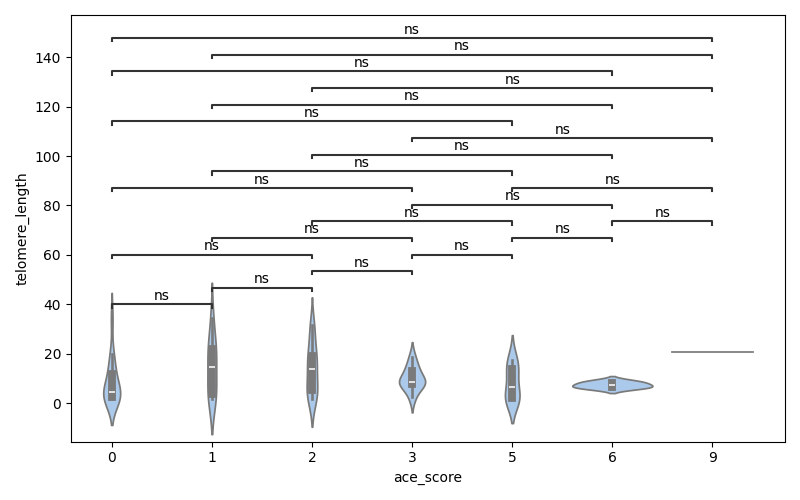

In [13]:
test_fig, test_ax = plt.subplots(1, 1, figsize=(8, 5))

sns.violinplot(x=data.ace_score, y=data.telomere_length)

annotator = Annotator(
    ax=test_ax,
    pairs=pairs,
    x=data.ace_score,
    y=data.telomere_length,
)
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()

test_fig.tight_layout()